In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
df = pd.read_csv('NYC311data.csv', parse_dates=['Created Date','Closed Date','Resolution Action Updated Date'])
df.info()

C:\Users\prath\AppData\Local\Temp\ipykernel_17424\1695197811.py:1: DtypeWarning: Columns (48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NYC311data.csv', parse_dates=['Created Date','Closed Date','Resolution Action Updated Date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      300698 non-null  int64         
 1   Created Date                    300698 non-null  datetime64[ns]
 2   Closed Date                     298534 non-null  datetime64[ns]
 3   Agency                          300698 non-null  object        
 4   Agency Name                     300698 non-null  object        
 5   Complaint Type                  300698 non-null  object        
 6   Descriptor                      294784 non-null  object        
 7   Location Type                   300567 non-null  object        
 8   Incident Zip                    298083 non-null  float64       
 9   Incident Address                256288 non-null  object        
 10  Street Name                     256288 non-null  object 

In [3]:
def convert_lower(df):
    df = df.applymap(lambda s:s.lower() if type(s) == str else s)
    return df

def drop_empty_columns(df):
    na_col_count = df.isna().sum().where(lambda x:x>0).dropna()
    columns_to_drop = []
    for column in na_col_count.iteritems():
        if(column[1]/8275 >= 0.85):
            columns_to_drop.append(column[0])
    df.drop(columns_to_drop, axis=1, inplace=True)
    return df

def drop_unneccessary_columns(df):
    cols = ['Descriptor','Location','Address Type','Facility Type','Agency','Agency Name','Community Board','Borough','Park Facility Name','Park Borough','School Region','School Code', 'School Name','School Number','School Phone Number','School Address','School City','School State','School Not Found','School Zip','X Coordinate (State Plane)','Y Coordinate (State Plane)']
    df.drop(cols,axis=1,inplace=True)
    return df


In [4]:
df = drop_empty_columns(df)
df = drop_unneccessary_columns(df)
df = convert_lower(df)
df.isna().sum().where(lambda x:x>0).dropna()

Closed Date                       2164.0
Location Type                      131.0
Incident Zip                      2615.0
City                              2614.0
Due Date                             3.0
Resolution Action Updated Date    2187.0
Latitude                          3540.0
Longitude                         3540.0
dtype: float64

In [5]:
df = df[~(df['Closed Date'].isna() & df['Resolution Action Updated Date'].isna())]
df.loc[df['Closed Date'].isna(),'Closed Date'] = df[df['Closed Date'].isna()]['Resolution Action Updated Date']
df.loc[df['Resolution Action Updated Date'].isna(),'Resolution Action Updated Date'] = df[df['Resolution Action Updated Date'].isna()]['Closed Date']
df.loc[df['Due Date'].isna(),'Due Date'] = df[df['Due Date'].isna()]['Closed Date']

In [6]:
df.loc[df.Status.isin(['open','assigned','draft']),'Status'] = 'closed'

In [7]:
city = df.City.mode()[0]
zipcode = df.loc[df.City == city,'Incident Zip'].mode()[0]
latitude = df.loc[df['Incident Zip'] == zipcode,'Latitude'].mode()[0]
longitude = df.loc[df['Incident Zip'] == zipcode,'Longitude'].mode()[0]
df.loc[df.City.isna(),'Incident Zip'] = zipcode
df.loc[df.City.isna(),'City'] = city
df.loc[(df.City == city) & (df.Latitude.isna()==True),'Latitude'] = latitude
df.loc[(df.City == city) & (df.Longitude.isna()==True),'Longitude'] = longitude

In [8]:
df.isna().sum().where(lambda x:x>0).dropna()

Location Type    128.0
Incident Zip       4.0
Latitude         773.0
Longitude        773.0
dtype: float64

In [9]:
df.dropna(inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297646 entries, 0 to 300697
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Unique Key                      297646 non-null  int64         
 1   Created Date                    297646 non-null  datetime64[ns]
 2   Closed Date                     297646 non-null  datetime64[ns]
 3   Complaint Type                  297646 non-null  object        
 4   Location Type                   297646 non-null  object        
 5   Incident Zip                    297646 non-null  float64       
 6   City                            297646 non-null  object        
 7   Status                          297646 non-null  object        
 8   Due Date                        297646 non-null  object        
 9   Resolution Description          297646 non-null  object        
 10  Resolution Action Updated Date  297646 non-null  datetim

In [11]:
df.loc[:,'Request Closing Time(in hours)'] = (df['Closed Date'] - df['Created Date']).dt.total_seconds()

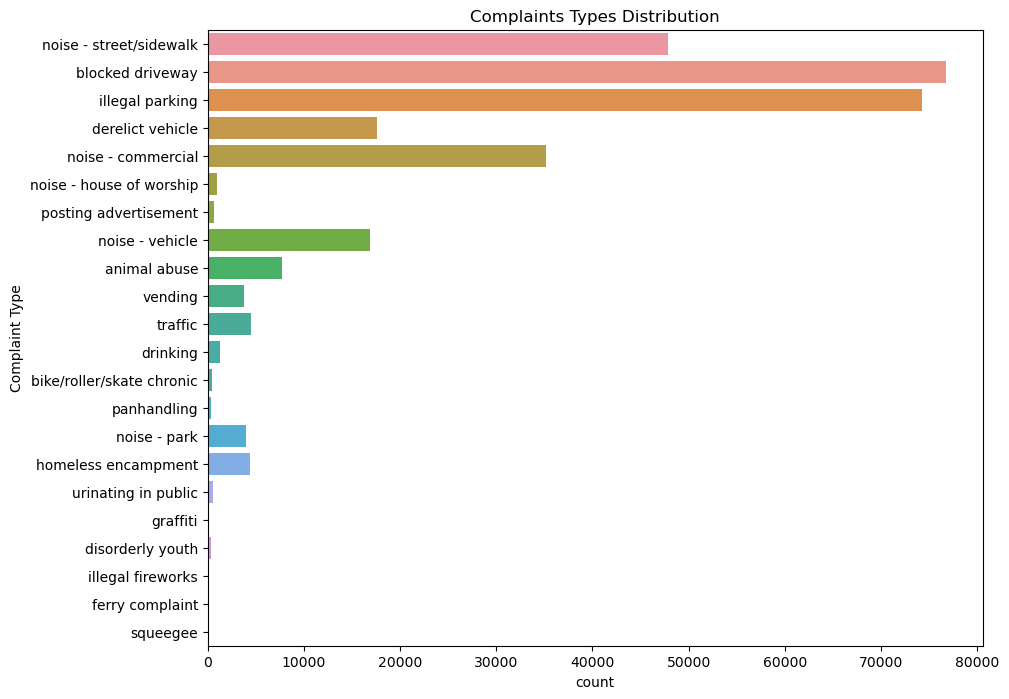

In [12]:
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='Complaint Type', data=df)
plt.show()

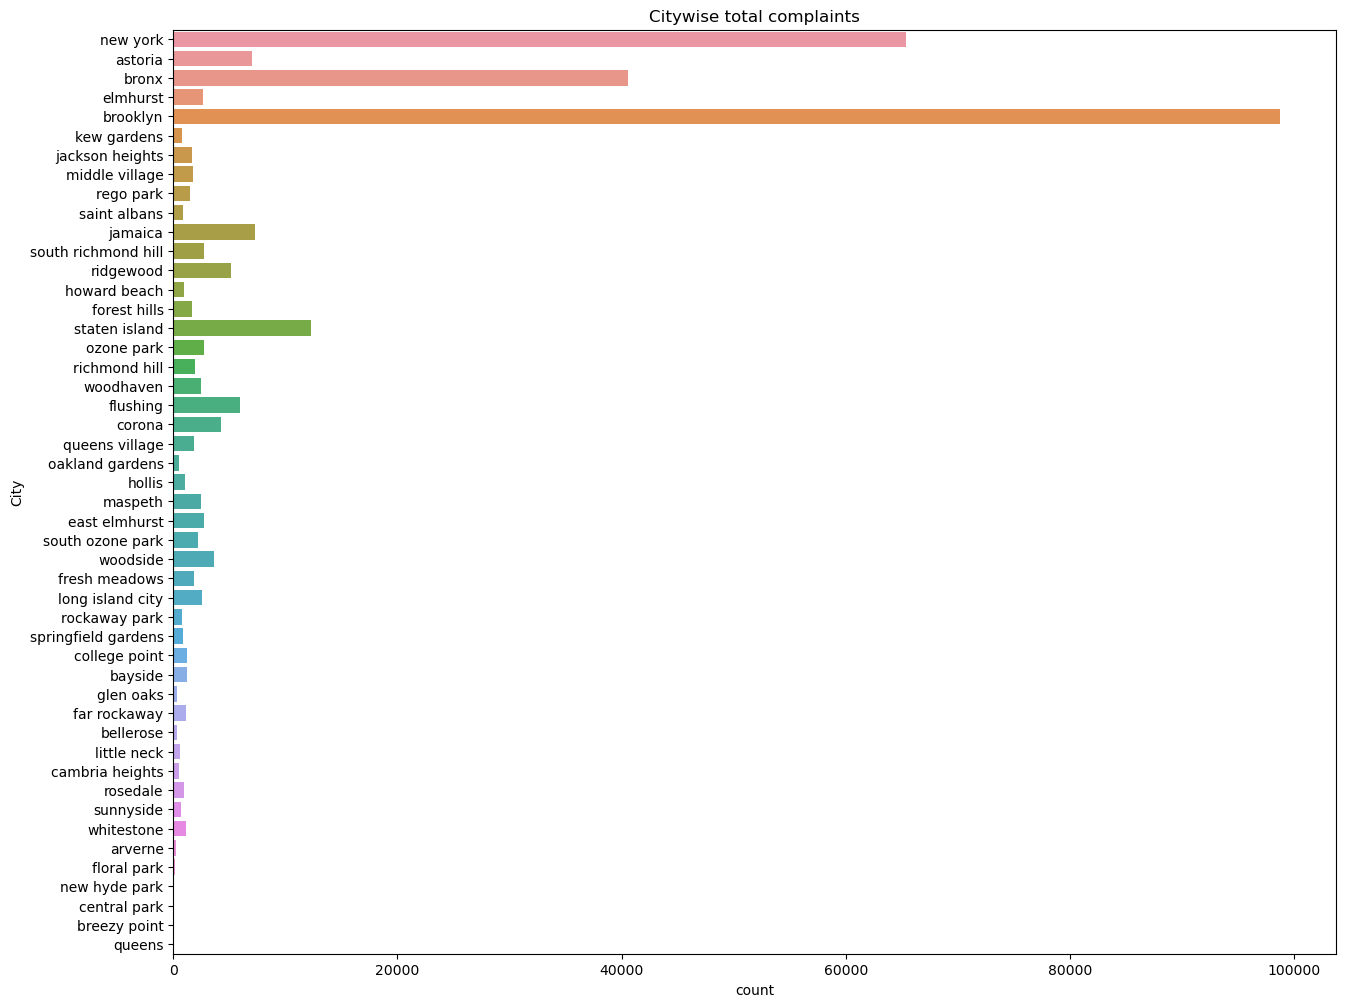

In [13]:
plt.figure(figsize=(15,12))
plt.title('Citywise total complaints')
sns.countplot(y='City',data=df)
plt.show()

In [14]:
top5cities = df['City'].value_counts().head(5).index.to_list()
dstop5 = df[df.City.isin(top5cities)]
df1 = pd.crosstab(dstop5['City'],dstop5['Complaint Type'])

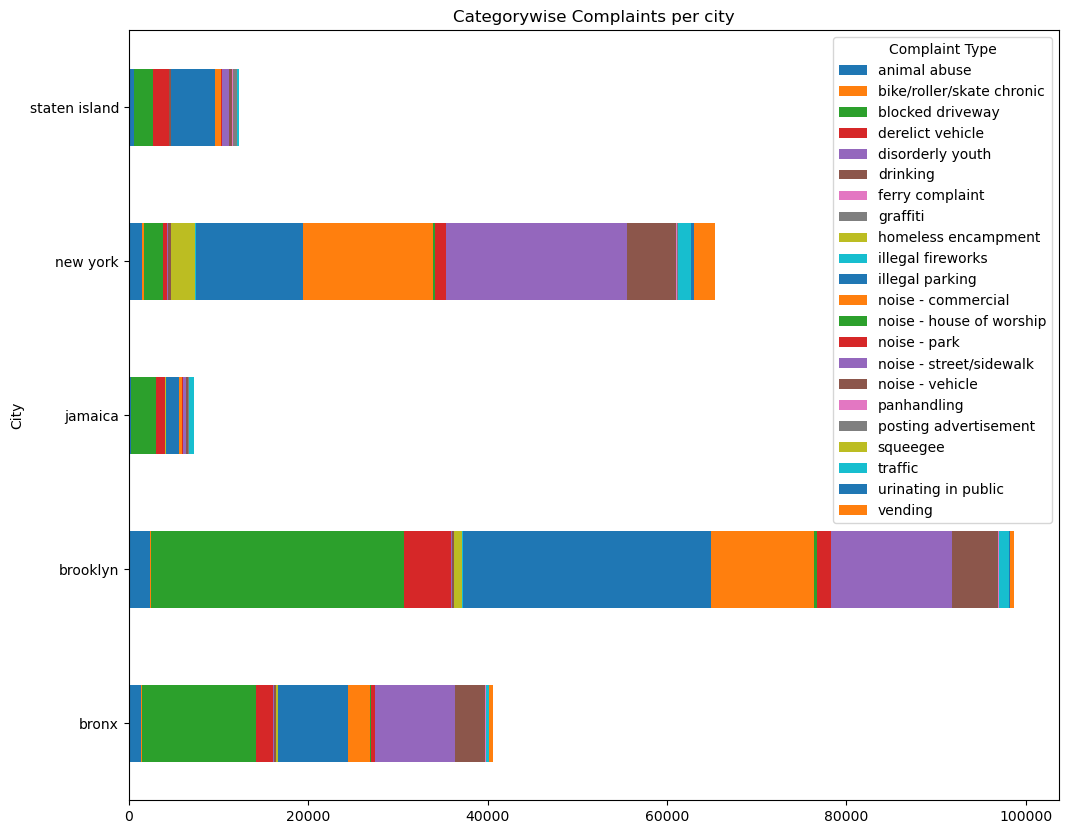

In [15]:
df1.plot(kind='barh',stacked=True,figsize=(12,10))
plt.title('Categorywise Complaints per city')
plt.show()

In [16]:
complaintTypes = df['Complaint Type'].unique()

for i in range(len(complaintTypes)):
    exec("c{} = df.loc[(df['Complaint Type'] == '{}'),'Request Closing Time(in hours)']".format(i+1,complaintTypes[i]))

In [17]:
fscore,pvalue = stats.f_oneway(c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16)
print(fscore, pvalue)

541.0488206762245 0.0


pvalue of 0 (<0.5) mean we reject null hypothesis(i.e complaint type doesn't affect on request closing time).

In [18]:
ctabDF = pd.crosstab(df['Complaint Type'],df['City'])

In [19]:
stat, p, dof, expected = chi2_contingency(ctabDF)
print('Chi-Square Statistic Value: ',stat)
print('p value: ',p)
print('degrees of freedom: ',dof)

Chi-Square Statistic Value:  109359.08964937081
p value:  0.0
degrees of freedom:  987
